In [1]:
import cvxpy as cp
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.io
# mosek only needed if we don't use MW
#import mosek
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import cProfile
#from baselines import *
from scipy.linalg import sqrtm

In [2]:
#synthetic example with N datapoints, in d dimensions, with k actions, random regressors
#returns a dictionary of covariates x, labels y, regressors ell.  
def synthetic_example(N,d,k):
    #covariates
    x = np.random.normal(0,1,(N,d))
    #regressors
    ell = np.random.normal(0,1,(k,d))
    #labels
    y = np.zeros((N,k))
    for i in range(N):
        for j in range(k):
            feature = x[i,:]
            regressor = ell[j,:]
            y[i,j] = np.inner(feature,regressor) + np.random.normal(0,1)
    data = {'cov': x, 'label': y, 'reg': ell}
    return data

from scipy.special import logit, expit

def logistic_synthetic_example(N,d,k,eta,corrupt=False):
    #covariates, scaling the covariates to be of large norm amplifies the effect of corruptions
    #good parameters: scale x by 100, d = 100, N = 1000
    x = np.random.normal(0,1,(N,d))*100
    #regressors
    ell = np.random.normal(0,1,(k,d))
    ell = ell/np.linalg.norm(ell)
    #labels
    y = np.zeros((N,k))
    prob_list = np.zeros((N,k))
    for i in range(N):
        for j in range(k):
            feature = x[i,:]
            regressor = ell[j,:]
            prob = expit(np.inner(feature,regressor))
            prob_list[i,j] = prob
            y[i,j] = np.random.binomial(1,prob)
            #deterministic labels
            #if prob > 0.5:
            #    y[i,j] = 1
            #else:
            #    y[i,j] = 0
    if corrupt:
        corr = int(eta*N)
        print('number of corruptions')
        print(corr)
        poison = False
        if poison:
            print('TODO: poisoning')
        else: 
            select = np.zeros((corr,k))
            for j in range(k):
                order = np.argsort(prob_list[:,j])
                select[:,j] = order[:corr]
            for i in range(corr):
                for j in range(k):
                    index = int(select[i,j])
                    y[index,j] = 1 - y[index,j]
    data = {'cov': x, 'label': y, 'reg': ell}
    return data

#data = synthetic_example(1000,100,10)    
#print(data)

import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels


data_mode = 'logistic_synth'
#data_mode = 'synthetic'
#data_mode = 'real'
N = 1000
d = 1
k = 1
eta = 0.1

if data_mode == 'logistic_synth':
    data = logistic_synthetic_example(N,d,k,eta,corrupt=True)
    #data = logistic_synthetic_example(N,d,k,eta,corrupt=False)
if data_mode == 'synthetic':
    data = synthetic_example(1000,10,10)    
elif data_mode == 'real': 
    x, y = parse_data("Bibtex_data.txt")
    print(x.shape)
    print(y.shape)
    data = {'cov': x, 'label': y}

x = data['cov']
y = data['label']

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', random_state=0, fit_intercept ='False')
#a = np.zeros((2,3)).reshape(-1,1)
#b = np.ones(2)

#a = np.zeros(10,2).reshape(-1, 1)
#b = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
lab = y[:,0]
model.fit(x, lab)
print(model.coef_)
print(data['reg'])
print('score')
print(model.score(x,lab))

vanilla = model.coef_

number of corruptions
100
[[0.01199511]]
[[1.]]
score
0.714


In [3]:
# #logistic regression experiments
# #implement the weighted logistic regression
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import InputLayer
# from scipy.special import expit,logit

# #line of code to enable the numpy operations in the custom loss
# #to be replaced
# #tf.config.run_functions_eagerly(True)

# x_train = data['cov']
# y_train = y[:,0]


# ANN_model = Sequential()
# ANN_model.add(InputLayer(input_shape=(d, )))
# # No hidden layers
# ANN_model.add(Dense(1, activation='sigmoid',use_bias=False))
# ANN_model.summary()

# b_size = 10

# def custom_loss_function(y_true, y_pred):
#     dim = y_true.shape[0]
#     arg1 = y_true[:,0]
#     arg2 = tf.math.log(y_pred[:,0])
#     arg3 = tf.subtract(tf.ones(dim),arg1)
#     arg4 = tf.subtract(tf.ones(dim),arg2)
#     inp1 = tf.multiply(arg1,arg2)
#     inp2 = tf.multiply(arg3,arg4)
#     loss_vec = tf.math.scalar_mul(-1.0,tf.add(inp1,inp2))
#     output = tf.reduce_mean(loss_vec, axis=-1)
#     return output

# opt=tf.keras.optimizers.Adam(learning_rate=0.01)
# #loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)
# #ANN_model.compile(optimizer=opt,
# #                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
# #                  metrics=['accuracy'])

# ANN_model.compile(optimizer=opt,
#                   loss=custom_loss_function,
#                   metrics=['accuracy'])


# history = ANN_model.fit(x_train, y_train, 
#                         epochs=10, batch_size=b_size,
#                         validation_split=0.2, 
#                         shuffle=True)

In [4]:
#arg = tf.constant(x_train[0,:])
#arg = tf.ones((1,100))
#print(arg.shape)
#print('prediction: ',ANN_model.predict(arg))

#g = ANN_model.get_layer(index=0).get_weights()
from scipy.special import expit,logit 
#arg = np.ones(100)
#h = g[0][:,0]
#print(h.shape)
#print(np.inner(arg,arg))
#print(arg.shape)

#print(np.inner(h,h))
#print('prediction: ', expit(np.inner(h,arg)))

#b = ANN_model.get_layer(index=0).name
#print(b)

In [6]:
#logistic regression version of scram
from scipy.linalg import eigh

def logistic_reg_oracle(x,y,mode='robust-logistic'):
    if mode == 'robust-logistic':
        lr = 0.1
        #lam = 0.2
        lam = 0.0
        MW_steps = 30
        #eta = 0.1
        AM_steps = 100
        params = (AM_steps,lr,lam,MW_steps,eta)
        #print('enerting logistic scram')
        regressor = logistic_scram(x,y,params)
    return regressor

def logistic_scram(x,y,params):
    AM_steps = params[0]
    altmin_params = params[1:]
    N,d = x.shape
    w = [0.]*d
    a = [1.]*N
    #TODO: fix isotropic step, for now identity covariance
    #iso_x, Sig_sqrt = isotropic(x)
    iso_x = x
    Sig_sqrt = np.eye(d)
    for i in range(AM_steps):
        #print('AM step: ',i)
        #print('entering logistic altmin step')
        w,a = logistic_altmin_step(iso_x,y,a,altmin_params)
    final_w = np.matmul(Sig_sqrt,w)    
    return final_w

def logistic_altmin_step(Xs,Ys,a,params):
    N,d = Xs.shape
    w = weighted_logistic_reg(Xs,Ys,a)
    a = logistic_get_weights(Xs,Ys,w,params)
    return w, a

def weighted_logistic_reg(x,y,a):
    n,d = x.shape
    hard_weights = np.zeros(n)
    m = min(int(n*(1 - eta))+1,n) 
    prob = a*m
    for i in range(N):
        ind = np.random.binomial(1,prob[i])
        hard_weights[i] = ind
    
    N_train = int(np.sum(hard_weights))
    #print('N_train: ',N_train)
    x_train = np.zeros((N_train,d)) 
    y_train = np.zeros(N_train)
    
    hold = 0
    for i in range(N):
        if hard_weights[i] == 1:
            x_train[hold,:] = x[i,:]
            y_train[hold] = y[i]
            hold = hold + 1
    model = LogisticRegression(solver='liblinear', random_state=0, fit_intercept ='False')
    #lab = y[:,0]
    model.fit(x_train, y_train)
    #print('regressor shape: ', model.coef_.shape)
    regressor = model.coef_[0,:]
    #print('regressor shape: ', regressor.shape)
    return regressor

def logistic_get_weights(X,y,w,params):
    n,d = X.shape
    lr,lam,steps,eta = params
    a = np.ones(n)/float(n)
    #Sig = np.cov(X.T)
    Sig = np.matmul(X.T,X)
    #print('y: ', y.shape)
    #print('X: ', X.shape)
    #print('w: ', w.shape)
    #print('Xw:', np.matmul(X,w).shape)
    Xw = np.matmul(X,w)
    pred = expit(Xw)
    resids = np.absolute(y - pred)

    #print("begin MW")
    for j in range(steps):
        #if j % 10 == 0:
        #    print(j)
        if lam > 0:
            v = v_step(a,X,Sig,eta)
        else:
            v = np.zeros(d)
        a = a_step(a,X,resids,v,lr=lr,lam=lam,eta=eta,n=n)
    return a

def outerprod(a,X):
    """ Compute X^T diag(a) X """
    left = np.multiply(X.T,a)
    return np.dot(left,X)

def cap(a,m):
    if np.max(a) <= 1./m:
        return a
    #sorted_a = np.sort(a)
    ## BUG FIX: use -a to get descending order
    sort_ids = np.argsort(-a)

    # Faster code
    Z = np.sum(a)
    for i in range(1,m + 1):
        Z -= a[sort_ids[i - 1]]
        aprime_next = (m - i) * a[sort_ids[i]]/float(m * Z)
        if aprime_next <= 1.0/m:
            aprime = np.copy(a)
            aprime[sort_ids[:i]] = 1./m
            aprime[sort_ids[i:]] *= (m - i)/float(m * Z)
            return aprime

def v_step(a,X,Sig,eta,tol=0):
    """ Compute top eigenvector of X^T diag(1/n-a) X"""
    # Bug fix: this was formerly 1 and not 1/n
    n = a.shape[0]
    #m = int(n*(1 - eta)) 
    M = outerprod(1./n-a,X)

    # this method is slower sometimes and faster sometimes vs other one, depending on d?
    d = M.shape[0]

    # Want top eigenvalue algebraically
    eigenvalue, v = eigh(M, eigvals=(d-1,d-1)) 
    #eigenvalue, v = largest_eigsh(M, 1, which='LA',tol=tol)
    #print(eigenvalue)
    #print(np.sum(v ** 2))
    
    ## Don't regularize if constraint is satisfied
    if eigenvalue > 0:
        return v[:,0]
    else:
        return np.zeros(shape=v[:,0].shape)
    
# @jit(nopython=True)
def a_step(a,X,resids_sq,v,lr,lam,eta,n):
    """ Step to minimize \sum_i a_i resids_sq[i]^2 + \lambda sigma_{max}(X^T diag(1/n - a) X)"""
    m = min(int(n*(1 - eta))+1,n) 
    
    Xv_squared = np.dot(X,v)**2
    penalties = resids_sq - lam * Xv_squared

    #print("OBJ: ",np.dot(a,resids_sq), np.dot(a,-lam * Xv_squared) + lam * (1/n) * np.sum(Xv_squared))

    #print("BEFORE: ",np.dot(a,penalties) + lam * (1/n) * np.sum(Xv_squared))

    # multiplicative update
    #print('residuals: ',resids_sq.shape)
    #print('penalties: ', penalties.shape)
    a *= np.exp(-lr * penalties)
    a /= np.sum(a)
    #print("MIDDLE:: ",np.dot(a,penalties) + lam * (1/n) * np.sum(Xv_squared))
    # project back to sliced simplex
    #print('a: ', a)
    #print('m: ', m)
    a = cap(a,m)
    return a

def logistic_eval(x,y,reg):
    n,d = x.shape
    error = 0
    for i in range(n):
        error = error + np.absolute(y[i] - expit(np.inner(reg,x[i,:])))
        
    error = error/n
    return error 
    
reg = logistic_reg_oracle(x,y[:,0])
print('non robust performance: ', logistic_eval(x,y,vanilla))
print('robust performance: ',logistic_eval(x,y,reg))
print('vanilla: ', vanilla)
print('reg: ', reg)

non robust performance:  [0.37440813]
robust performance:  [0.19983483]
vanilla:  [[0.01199511]]
reg:  [0.05288764]


In [7]:
#plot experiments for logistic regression
def run_experiment():
    N = 1000
    d = 1
    k = 1
    eta_list = [0.05,0.1,0.15,0.2,0.25]
    results_robust = []
    results_vanilla = []
    for eta in eta_list: 
        data = logistic_synthetic_example(N,d,k,eta,corrupt=True)
        #data = logistic_synthetic_example(N,d,k,eta,corrupt=False)
        x = data['cov']
        y = data['label']
        #run vanilla logistic regression
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(solver='liblinear', random_state=0, fit_intercept ='False')
        lab = y[:,0]
        model.fit(x, lab)
        vanilla = model.coef_
        #run robust logistic regression
        reg = logistic_reg_oracle(x,lab)
        v_out = logistic_eval(x,y,vanilla)
        r_out = logistic_eval(x,y,reg)
        results_robust.append(r_out)
        results_vanilla.append(v_out)
        print('corruption level: ',eta)
        print('non robust performance: ', v_out)
        print('robust performance: ', r_out)
    return (results_robust,results_vanilla)  

(rob,nrob) = run_experiment()
print('robust: ', rob)
print('non robust: ', nrob)

number of corruptions
50
corruption level:  0.05
non robust performance:  [0.27196645]
robust performance:  [0.10967226]
number of corruptions
100
corruption level:  0.1
non robust performance:  [0.38265477]
robust performance:  [0.18533537]
number of corruptions
150
corruption level:  0.15
non robust performance:  [0.42906523]
robust performance:  [0.32104217]
number of corruptions
200
corruption level:  0.2
non robust performance:  [0.46198642]
robust performance:  [0.42228936]
number of corruptions
250
corruption level:  0.25
non robust performance:  [0.48364935]
robust performance:  [0.46821579]
robust:  [array([0.10967226]), array([0.18533537]), array([0.32104217]), array([0.42228936]), array([0.46821579])]
non robust:  [array([0.27196645]), array([0.38265477]), array([0.42906523]), array([0.46198642]), array([0.48364935])]


Text(0.5, 1.0, 'Logistic Regression vs. Logistic SCRAM')

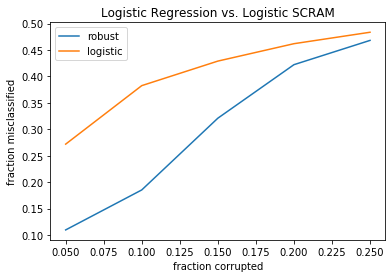

In [13]:
from matplotlib import pyplot as plt
eta_list = [0.05,0.1,0.15,0.2,0.25]
plt.plot(eta_list,rob,label='robust')
plt.plot(eta_list,nrob,label='logistic')
plt.ylabel('fraction misclassified')
plt.xlabel('fraction corrupted')
plt.legend()
plt.title('Logistic Regression vs. Logistic SCRAM')

In [ ]:
from mw2 import MW_no_alt_min, get_weights, altmin_step

def isotropic(Xs,fake=False):
    if fake:
        return Xs, np.eye(Xs.shape[1])
    Sig = np.matmul(Xs.T,Xs)
    Sig_sqrt = np.linalg.inv(sqrtm(Sig))
    new_Xs = np.matmul(Xs,Sig_sqrt)
    return new_Xs, Sig_sqrt

def scram(x,y,params):
    AM_steps = params[0]
    altmin_params = params[1:]
    N,d = x.shape
    w = [0.]*d
    a = [1.]*N
    #iso_x, Sig_sqrt = isotropic(x)
    iso_x = x
    Sig_sqrt = np.eye(d)
    AM_steps = 1
    for i in range(AM_steps):
        #print('AM step: ',i)
        w,a = altmin_step(iso_x,y,a,altmin_params,init=False)
    final_w = np.matmul(Sig_sqrt,w)    
    return final_w

#regression oracle 
def regression_oracle(x,y,mode='ols'):
    if mode == 'ols':
        model = LinearRegression()
        model.fit(x,y)
        regressor = model.coef_
    if mode == 'scram':
        lr = 0.5
        lam = 0.2
        MW_steps = 10
        eta = 0.1
        AM_steps = 10
        params = (AM_steps,lr,lam,MW_steps,eta)
        regressor = scram(x,y,params)
    return regressor


reg = regression_oracle(x,y[:,0])

def optimal_reward(y):
    a,b = y.shape
    cumsum = 0
    for i in range(a):
        cumsum = cumsum + np.amax(y[i,:])
    return cumsum/a

max_reward = optimal_reward(y)
print('Optimal Reward')
print(max_reward)

In [ ]:
#contextual bandits takes covariates and labels
def contextual_bandit(cov_label):
    cov = cov_label['cov']
    labels = cov_label['label']
    (N,d) = cov.shape
    (N,k) = labels.shape
    estimators = np.zeros((k,d))
    action_list = []
    mu = k
    delta = 0.1
    gamma = np.sqrt(k*N/(d*np.log(N/d) + 1./(2*delta)))
    params = (mu,gamma)
    rewards = []
    mean_reward = []
    for i in range(N):
        print('iteration: ',i)
        covariate = cov[i,:]
        values = np.zeros(k)
        for j in range(k):
            est = estimators[j,:]
            values[j] = np.inner(est,covariate)
        action = select_action(values,params)
        action_list.append(action)
        bandit_feedback = labels[i,action]
        rewards.append(bandit_feedback)
        (data_x,data_y) = get_data(cov_label,action_list,action) 
        
        #bug, ols can run on one datapoint but scram can't
        #estimators[action,:] = regression_oracle(data_x,data_y,mode='ols')
        estimators[action,:] = regression_oracle(data_x,data_y,mode='scram')
        print('action')
        print(action)
        print('average reward')
        #print(rewards)
        avg_reward = sum(rewards)/len(rewards)
        mean_reward.append(avg_reward)
        print(avg_reward)
    return mean_reward

def get_data(cov_label,action_list,action):
    cov = cov_label['cov']
    labels = cov_label['label']
    (N,d) = cov.shape
    (N,k) = labels.shape
    length = len(action_list)
    count = 0
    for i in range(length):
        if action_list[i] == action:
            count = count + 1
    
    data_x = np.zeros((count,d))
    data_y = np.zeros(count)
    counter = 0
    for i in range(len(action_list)):
        if action_list[i] == action:
            data_x[counter] = cov[i,:]
            data_y[counter] = labels[i,action]
            counter = counter + 1
    return (data_x,data_y) 


def select_action(values,params):
    (mu,gamma) = params
    k = mu
    max_value = np.amax(values)
    max_index = np.where(values == max_value)[0][0]
    prob = np.zeros(len(values))
    for i in range(k): 
        if i == max_index:
            next
        else: 
            prob[i] = 1./(mu + gamma*(max_value - values[i]))
    prob[max_index] = 1 - np.sum(prob)
    prob = prob/np.sum(prob)
    #print('probability')
    #print(prob)
    #TODO roulette wheel
    draw = np.random.rand()
    sums = 0
    action = 0
    for i in range(k):
        sums = sums + prob[i]
        if sums >= draw:
            action = i
            break
    return action

mean_reward = contextual_bandit(data)

In [ ]:
import matplotlib.pyplot as plt
domain = range(len(mean_reward))
plt.scatter(domain, mean_reward)
plt.show()

In [ ]:
a = np.array([[2,3],[1,4]])
b = np.sort(a,axis=0)
print(b)

In [ ]:
a = np.array([3,2,1])
order = a.argsort()
print(order)
b = a[order]
print(b)


In [ ]:
a = np.zeros((2,3))
a.shape[1]

In [ ]:
x = tf.constant([0.5,0.5,0.5])
y = tf.constant([1.,0.,1.])
weights = tf.constant([0.4,0.2,0.4])
t = tf.ones(3)


arg1 = tf.multiply(y,tf.math.log(x))
arg2 = tf.multiply(tf.subtract(t,y),tf.math.log(tf.math.subtract(t,x)))
q = tf.reduce_sum(tf.multiply(tf.add(arg1,arg2),weights))
print(q)

print(tf.math.scalar_mul(-1.0,x))

In [ ]:
print(x)

In [ ]:
a = tf.ones(2)
b = tf.ones(32)
c = b.numpy()
print(c)

In [ ]:
a = np.empty((0,2))
b = np.zeros((2,2))
c = np.array([b[0,:]])
print(c)
d = np.append(a,c,axis=0)
print(d)

In [ ]:
a = np.ones(3)
b = np.ones(3)
c = np.ones((3,3))
d = np.matmul(c,b)
print(d)

In [ ]:
a=5
a = a/10
a

In [ ]:
a = []
a.append(1)
print(a)